In [1]:
import utils
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm

INFO:root:Changing logging level


In [2]:
import matplotlib.pyplot as plt

In [3]:
import pyfolio as pf

/Users/pablovera/miniconda3/envs/timeseries/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [101]:
sns.set(rc = {'figure.figsize':(42,30)}, font_scale = 2)

In [5]:
engine = utils.get_engine()

In [89]:
def query (symb) :
    return f"""
            drop table if exists analytics.{symb}_monthly;
            create table analytics.{symb}_monthly as (
with numbered_rows as (
select s.date,
       date_trunc('month', s.date) as month,
       row_number() over (partition by to_char(s.date, 'yyyy'), date_trunc('month', s.date) order by s.date)=1 as is_first_row,
       row_number() over (partition by to_char(s.date, 'yyyy'), date_trunc('month', s.date) order by s.date desc)=1 as is_last_row,
       s.volume as stock_volume,
       s.open as stock_open,
       s.high as stock_high,
       s.low as stock_low,
       s.close as stock_close
from stocks.{symb}_1d s
where date>='2000-01-01'
)
    select month,
           sum(stock_volume) as volume,
           max(case when is_first_row then stock_open else -1 end) as open,
           max(case when is_last_row then stock_close else -1 end) as close,
           (max(case when is_last_row then stock_close else -1 end)/max(case when is_first_row then stock_open else -1 end) - 1) as return,
           min(stock_low) as low,
           max(stock_high) as high,
           max(stock_volume) max_volume,
           min(stock_volume) min_volume
    from numbered_rows
    group by 1)
            """

def return_query():
    return """select spy.month,
        (spy.close/lag(spy.close,1)over(order by spy.month) - 1) as spy_return,
        (xle.close/lag(xle.close,1)over(order by spy.month) - 1) as xle_return,
        (qqq.close/lag(qqq.close,1)over(order by spy.month) - 1) as qqq_return,
        (dia.close/lag(dia.close,1)over(order by spy.month) - 1) as dia_return,
        --(eem.close/lag(eem.close,1)over(order by spy.month) - 1) as eem_return,
        --(efa.close/lag(efa.close,1)over(order by spy.month) - 1) as efa_return,
        --(ewj.close/lag(ewj.close,1)over(order by spy.month) - 1) as ewj_return,
        --(fxi.close/lag(fxi.close,1)over(order by spy.month) - 1) as fxi_return,
        --(vti.close/lag(vti.close,1)over(order by spy.month) - 1) as vti_return,
        --(xlf.close/lag(xlf.close,1)over(order by spy.month) - 1) as xlf_return,
        --(xlk.close/lag(xlk.close,1)over(order by spy.month) - 1) as xlk_return,
        --(psj.close/lag(psj.close,1)over(order by spy.month) - 1) as psj_return,
        --(itot.close/lag(itot.close,1)over(order by spy.month) - 1) as itot_return,
        --(awk.close/lag(awk.close,1)over(order by spy.month) - 1) as awk_return,
        --(pho.close/lag(pho.close,1)over(order by spy.month) - 1) as pho_return,
        --(pio.close/lag(pio.close,1)over(order by spy.month) - 1) as pio_return,
        --(cgw.close/lag(cgw.close,1)over(order by spy.month) - 1) as cgw_return,
        --(awr.close/lag(awr.close,1)over(order by spy.month) - 1) as awr_return,
        --cpi.all_items as inflation,
        treasury_yield_13_weeks.close/100.0 as risk_free_return_13_weeks,
        treasury_yield_5_years.close/100.0 as risk_free_return_5_years,
        treasury_yield_10_years.close/100.0 as risk_free_return_10_years
        

from analytics.spy_monthly spy
--inner join public.cpi_data cpi on cpi.date::date=spy.month::date
inner join analytics.xle_monthly as  xle on xle.month=spy.month
inner join analytics.qqq_monthly as  qqq on qqq.month=spy.month
inner join analytics.dia_monthly as  dia on dia.month=spy.month
--inner join analytics.eem_monthly as  eem on eem.month=spy.month
--inner join analytics.efa_monthly as  efa on efa.month=spy.month
--inner join analytics.ewj_monthly as  ewj on ewj.month=spy.month
--inner join analytics.fxi_monthly as  fxi on fxi.month=spy.month
--inner join analytics.vti_monthly as  vti on vti.month=spy.month
--inner join analytics.xlf_monthly as  xlf on xlf.month=spy.month
--inner join analytics.xlk_monthly as  xlk on xlk.month=spy.month
--inner join analytics.psj_monthly as  psj on psj.month=spy.month
--inner join analytics.itot_monthly as itot on itot.month=spy.month
--inner join analytics.awk_monthly as awk on awk.month=spy.month
--inner join analytics.pho_monthly as pho on pho.month=spy.month
--inner join analytics.pio_monthly as pio on pio.month=spy.month
--inner join analytics.cgw_monthly as cgw on cgw.month=spy.month
--inner join analytics.awr_monthly as awr on awr.month=spy.month
inner join analytics.treasury_yield_13_weeks_monthly as treasury_yield_13_weeks on treasury_yield_13_weeks.month=spy.month
inner join analytics.treasury_yield_5_years_monthly as treasury_yield_5_years on treasury_yield_5_years.month=spy.month
inner join analytics.treasury_yield_10_years_monthly as treasury_yield_10_years on treasury_yield_10_years.month=spy.month
order by 1 asc;"""



In [40]:
def sharpe_ratio(returns, risk_free_return):
    excess_return = returns-risk_free_return
    sr = excess_return.mean(axis=0)/excess_return.stddev(axis=0)

In [41]:
def draw_hist_and_dist(data):
    sns.set(rc = {'figure.figsize':(42,30)}, font_scale = 2)
    mu, std = norm.fit(data) 
    plt.hist(data, bins='auto', density=True, alpha=0.6, color='b')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 1000)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=3)
    title = "Mean={:.2f} / Std={:.2f}".format(mu, std)
    plt.title(title)
    plt.show()

In [42]:
symbols = ['spy', 'qqq', 'dia', 'eem', 'efa', 'ewj',
           'fxi', 'vti', 'xle', 'xlf', 'xlk', 'psj', 'itot', 
           'btcusd', 'ethusd', 'xmrusd', 'socl', 'haus', 
           'arkk', 'arkw', 'arkf', 'arkq', 'meli',
           'awk', 'pho', 'pio', 'cgw', 'awr', 
           'treasury_yield_13_weeks',
           'treasury_yield_5_years', 'treasury_yield_10_years']

In [43]:
len(symbols)

31

In [44]:
with engine.connect() as connection:
    for s in symbols:
        try:
            connection.execute(query(s))
            print(f"Monthly market data created for symbol {s}.")
        except:
            print(f"Error with symbol {s}")
        finally:
            print(f"Error with symbol {s}")
    connection.close()

Monthly market data created for symbol spy.
Error with symbol spy
Monthly market data created for symbol qqq.
Error with symbol qqq
Monthly market data created for symbol dia.
Error with symbol dia
Monthly market data created for symbol eem.
Error with symbol eem
Monthly market data created for symbol efa.
Error with symbol efa
Monthly market data created for symbol ewj.
Error with symbol ewj
Monthly market data created for symbol fxi.
Error with symbol fxi
Monthly market data created for symbol vti.
Error with symbol vti
Monthly market data created for symbol xle.
Error with symbol xle
Monthly market data created for symbol xlf.
Error with symbol xlf
Monthly market data created for symbol xlk.
Error with symbol xlk
Monthly market data created for symbol psj.
Error with symbol psj
Monthly market data created for symbol itot.
Error with symbol itot
Monthly market data created for symbol btcusd.
Error with symbol btcusd
Monthly market data created for symbol ethusd.
Error with symbol eth

In [45]:
selected_constituents = ['spy', 'qqq', 'dia', 'eem', 'efa', 'ewj',
                           'fxi', 'vti', 'xle', 'xlf', 'xlk', 'psj', 'itot', 
                           'btcusd', 'ethusd', 'xmrusd', 'socl', 'haus', 
                           'arkk', 'arkw', 'arkf', 'arkq', 'meli',
                           'awk', 'pho', 'pio', 'cgw', 'awr']

In [90]:
with engine.connect() as connection:
    df_return = pd.read_sql(return_query(), con=connection)
    connection.close()

In [91]:
df_return.set_index('month', inplace=True)

In [92]:
df_return

,spy_return,xle_return,qqq_return,dia_return,risk_free_return_13_weeks,risk_free_return_5_years,risk_free_return_10_years
month,,,,,,,
2000-01-01,NaN,NaN,NaN,NaN,0.05530,0.06692,0.06667
2000-02-01,-0.015226,-0.042334,0.190244,-0.072489,0.05640,0.06593,0.06409
2000-03-01,0.094134,0.120669,0.025761,0.077538,0.05720,0.06332,0.06023
2000-04-01,-0.035121,-0.014925,-0.134703,-0.017133,0.05650,0.06552,0.06214
2000-05-01,-0.015723,0.117424,-0.122691,-0.020918,0.05490,0.06532,0.06285
...,...,...,...,...,...,...,...
2022-10-01,0.081276,0.249653,0.039999,0.139645,0.03975,0.04248,0.04077
2022-11-01,0.055592,0.012778,0.055442,0.057205,0.04253,0.03832,0.03703
2022-12-01,-0.061936,-0.040373,-0.092310,-0.042814,0.04260,0.04000,0.03879


In [106]:
periods=12*3

In [107]:
annualized_returns = df_return[['spy_return', 'qqq_return', 'dia_return']].apply(lambda x: ((x+1)**(12))-1)
risk_free_return = df_return["risk_free_return_10_years"]#.apply(lambda x: ((x+1)**(1/12))-1)



In [108]:
risk_free_return

month
2000-01-01    0.06667
2000-02-01    0.06409
2000-03-01    0.06023
2000-04-01    0.06214
2000-05-01    0.06285
               ...   
2022-10-01    0.04077
2022-11-01    0.03703
2022-12-01    0.03879
2023-01-01    0.03529
2023-02-01    0.03932
Name: risk_free_return_10_years, Length: 278, dtype: float64

In [109]:
annualized_returns

,spy_return,qqq_return,dia_return
month,,,
2000-01-01,NaN,NaN,NaN
2000-02-01,-0.168163,7.084098,-0.594649
2000-03-01,1.943369,0.356922,1.450154
2000-04-01,-0.348856,-0.823810,-0.187288
2000-05-01,-0.173181,-0.792112,-0.224060
...,...,...,...
2022-10-01,1.554092,0.601005,3.799935
2022-11-01,0.914039,0.910778,0.949437
2022-12-01,-0.535709,-0.687211,-0.408497


In [110]:
excess_return = annualized_returns.apply(lambda x: x-risk_free_return, axis=0)

In [111]:
sharpe_ratio = (excess_return.rolling(periods).mean()/excess_return.rolling(periods).std())*(12**0.5)

In [112]:
sharpe_ratio

,spy_return,qqq_return,dia_return
month,,,
2000-01-01,NaN,NaN,NaN
2000-02-01,NaN,NaN,NaN
2000-03-01,NaN,NaN,NaN
2000-04-01,NaN,NaN,NaN
2000-05-01,NaN,NaN,NaN
...,...,...,...
2022-10-01,1.321346,1.459064,1.169185
2022-11-01,1.354019,1.479891,1.198225
2022-12-01,1.242270,1.356721,1.129909


<AxesSubplot:xlabel='month'>

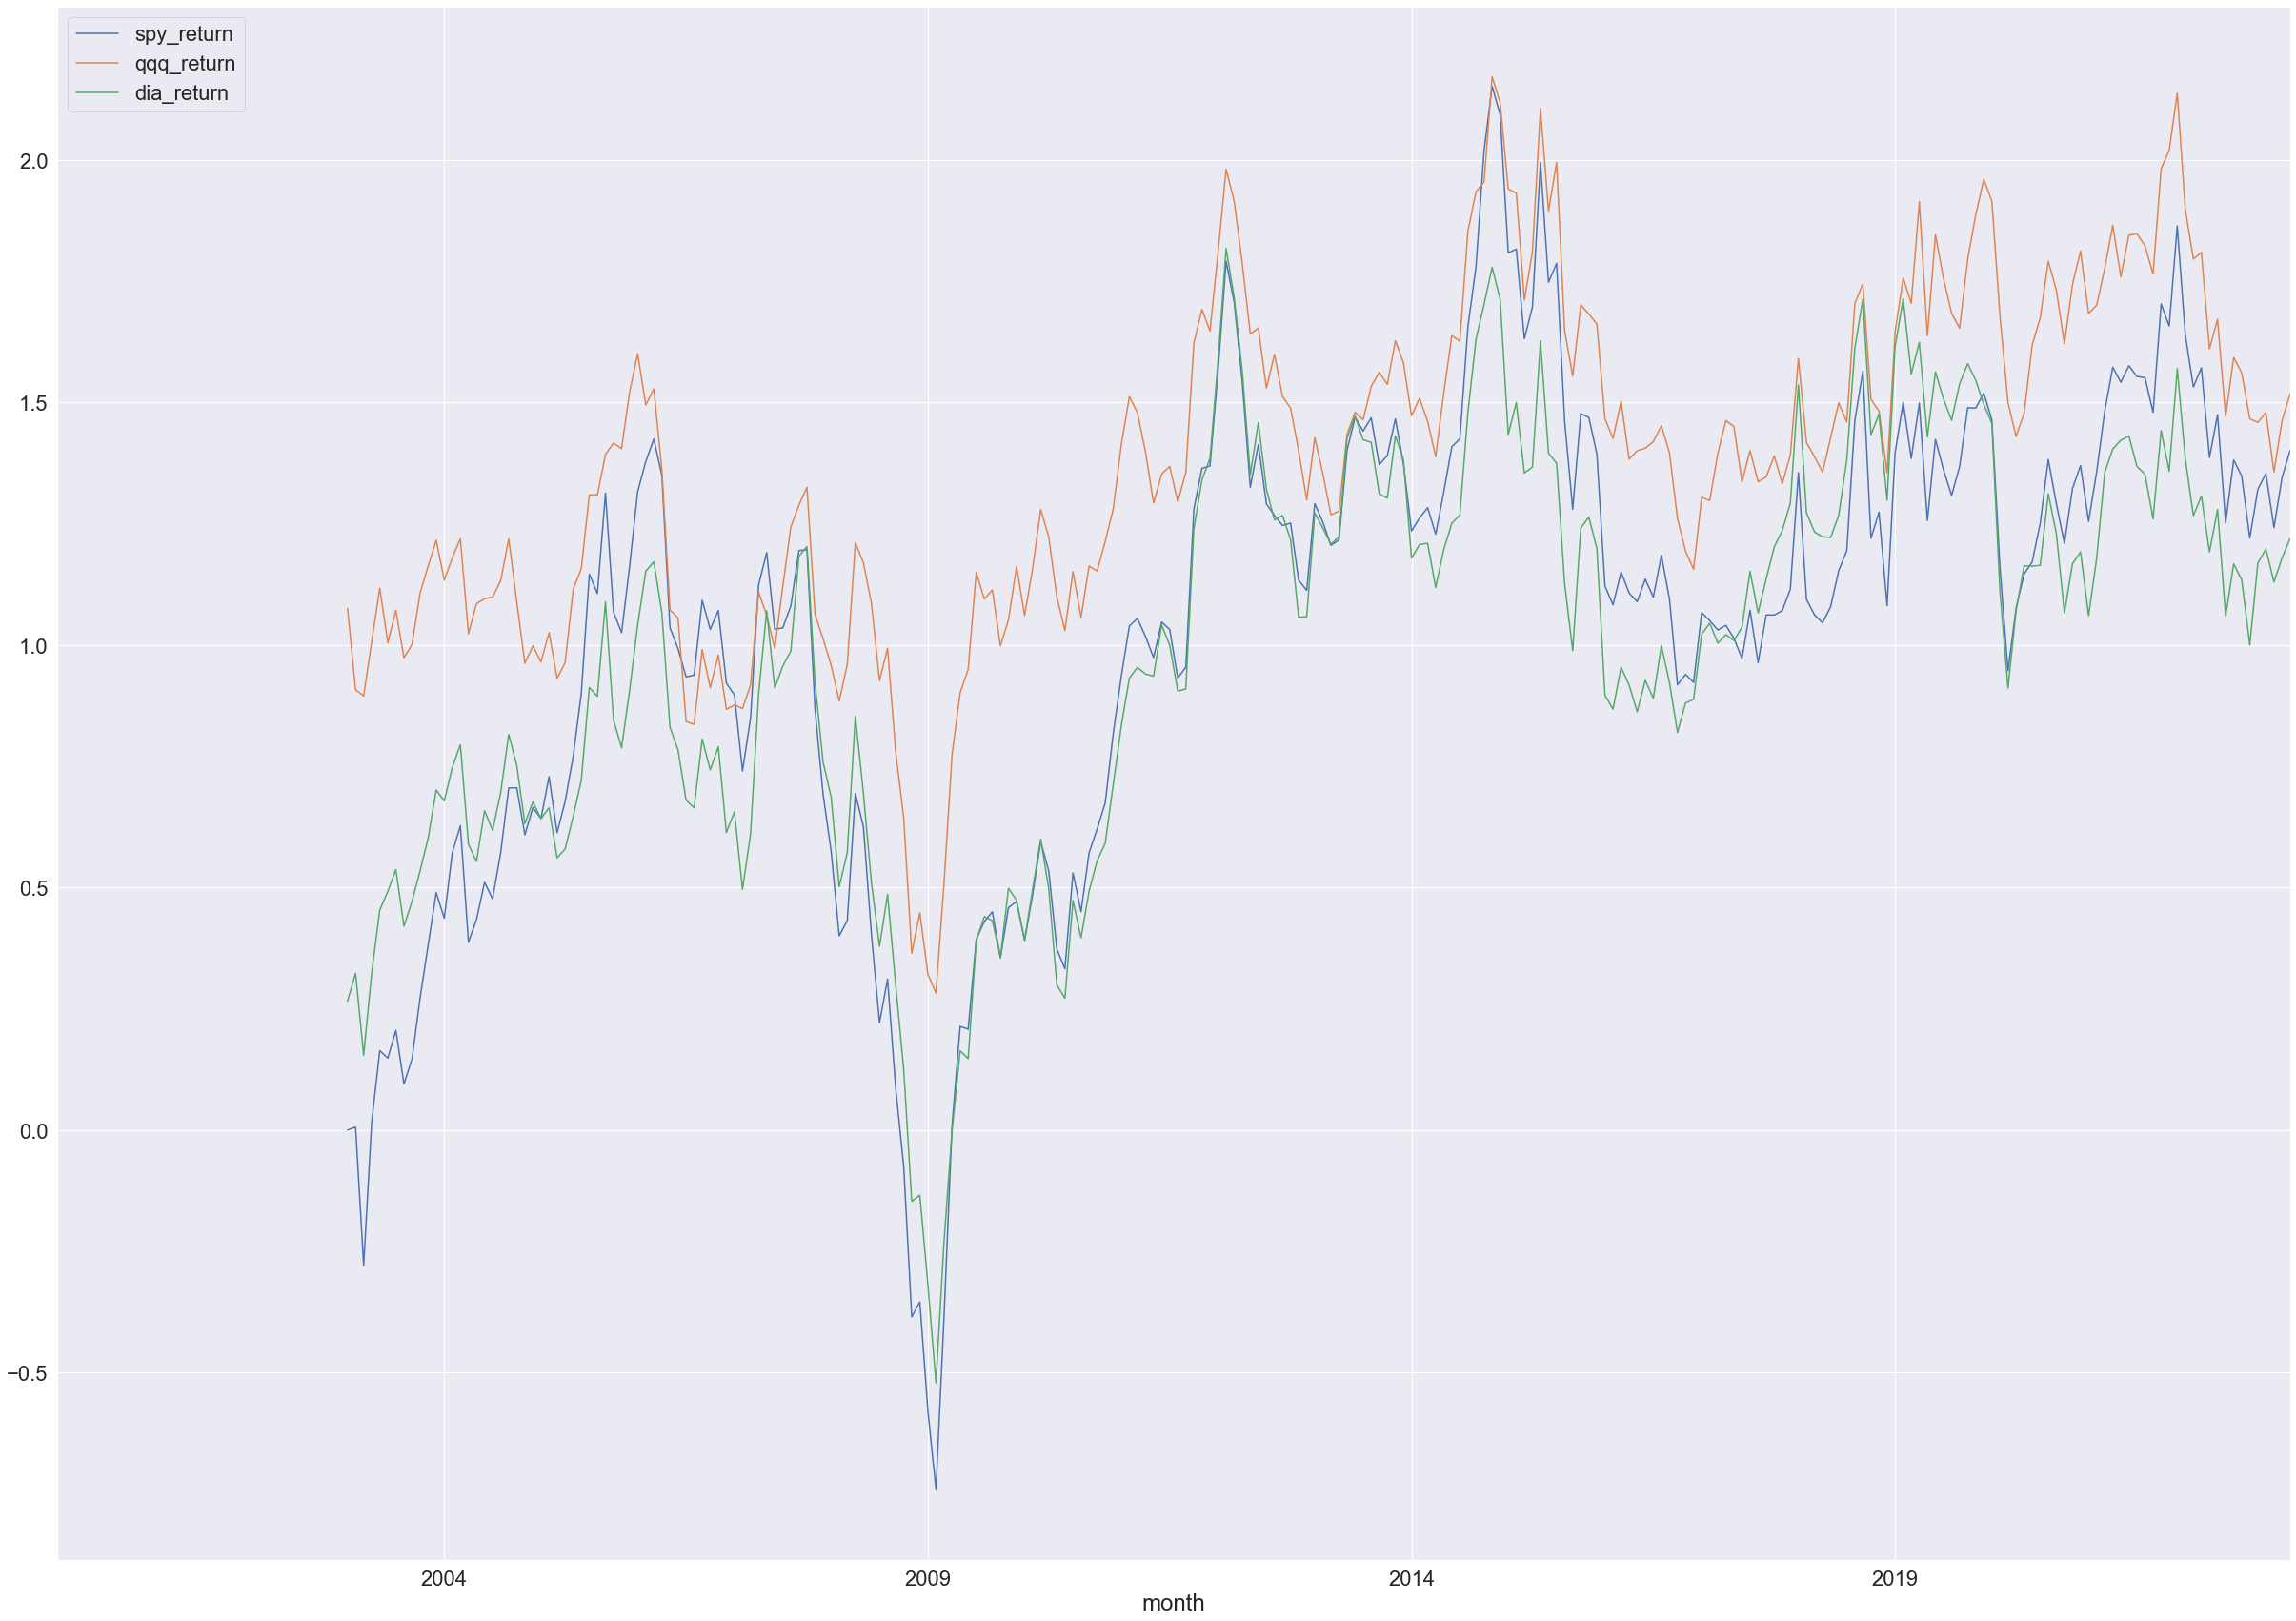

In [113]:
sharpe_ratio.plot()


In [24]:
excess_return.apply(lambda x: np.log(x+1)).rolling(periods).mean().apply(lambda x: np.exp(x)-1)

,spy_return,qqq_return,dia_return,vti_return
month,,,,
2008-04-01,NaN,NaN,NaN,NaN
2008-05-01,NaN,NaN,NaN,NaN
2008-06-01,NaN,NaN,NaN,NaN
2008-07-01,NaN,NaN,NaN,NaN
2008-08-01,NaN,NaN,NaN,NaN
...,...,...,...,...
2022-10-01,0.414000,0.839081,0.275599,0.403814
2022-11-01,0.409396,0.827852,0.268542,0.399110
2022-12-01,0.400881,0.808368,0.259986,0.390563
